<a href="https://colab.research.google.com/github/Captaingreenbeard/DataAnalyticsLab_SEM7/blob/main/lab_6_email_classification__preprocessing_and_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras import losses, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from tensorflow.keras.layers import (Convolution2D, Dense, Dropout, GlobalAveragePooling2D, 
                              GlobalMaxPool2D, Input, MaxPool2D, concatenate, Activation,  
                              MaxPooling2D,Flatten,BatchNormalization, Conv2D,AveragePooling2D)
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.datasets import load_iris 
from sklearn.datasets import make_moons 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn import utils
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# Problem 1.1 – Loading the Dataset

In [2]:
data = pd.read_csv("emails.csv")

In [3]:
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
is_null = pd.isnull(data).sum()
print('The number of empty values by column:')
print(is_null)

The number of empty values by column:
text    0
spam    0
dtype: int64


clean dataset; can go onto the second step of preparing the corpus

In [5]:
data.shape

(5728, 2)

In [6]:
data.nunique()

text    5695
spam       2
dtype: int64

In [7]:
data['spam'].value_counts(dropna=False)

0    4360
1    1368
Name: spam, dtype: int64

In [8]:
len(data['text'].max())

1032

# Answers to the questions of Problem 1.1

Q) How many emails are in the dataset?

Ans) 5728

Q) How many of the emails are spam?

Ans) 1368

Q) Which word appears at the beginning of every email in the dataset? 

Ans) subject

Q) Could a spam classifier potentially benefit from including the frequency of the word that appears in every email?

Ans) No -- the word appears in every email so this variable would not help us differentiate spam from ham.

Q) How many characters are in the longest email in the dataset (where longest is measured in terms of the maximum number  of characters)?

Ans) 1032

# Problem 2.1 -Preparing the Corpus

In [9]:
#2 convert the text to lowercase
data['text'] = data['text'].str.lower()

In [10]:
data.head()

,text,spam
0,subject: naturally irresistible your corporate...,1
1,subject: the stock trading gunslinger fanny i...,1
2,subject: unbelievable new homes made easy im ...,1
3,subject: 4 color printing special request add...,1
4,"subject: do not have money , get software cds ...",1


In [11]:
#3 removing all punctuation from dataset
data["text"] = data['text'].str.replace('[^\w\s]','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [12]:
data.head()

,text,spam
0,subject naturally irresistible your corporate ...,1
1,subject the stock trading gunslinger fanny is...,1
2,subject unbelievable new homes made easy im w...,1
3,subject 4 color printing special request addi...,1
4,subject do not have money get software cds fr...,1


In [13]:
##Let us remove the 'subject' from each of the texts; its absoloutely useless              
data['text'] = data["text"].str.replace("subject","")

In [14]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [16]:
def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

In [17]:
#4 removing all English stopwords from the dataset
data['text'] = data['text'].apply(remove_stopwords)

In [18]:
data.head()

,text,spam
0,naturally irresistible corporate identity lt r...,1
1,stock trading gunslinger fanny merrill muzo co...,1
2,unbelievable new homes made easy im wanting sh...,1
3,4 color printing special request additional in...,1
4,money get software cds software compatibility ...,1


In [19]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [20]:
def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

In [21]:
#5 stem the words in the dataset
data['text'] = data['text'].apply(perform_stemming)

In [22]:
data.head()

,text,spam
0,natur irresist corpor ident lt realli hard rec...,1
1,stock trade gunsling fanni merril muzo colza a...,1
2,unbeliev new home made easi im want show homeo...,1
3,4 color print special request addit inform cli...,1
4,money get softwar cd softwar compat great grow...,1


In [23]:
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
vec = CountVectorizer()
X = vec.fit_transform(data['text'])

In [25]:
#6  Build a document term matrix from the dataset, called dtm.
dtm = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
dtm.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,0000,000000,00000000,0000000000,000000000003619,000000000003991,000000000003997,000000000005168,...,zwzm,zxghlajf,zyban,zyc,zygoma,zymg,zzmacmac,zzn,zzncacst,zzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Q) How many terms are in dtm?

Ans) 29251

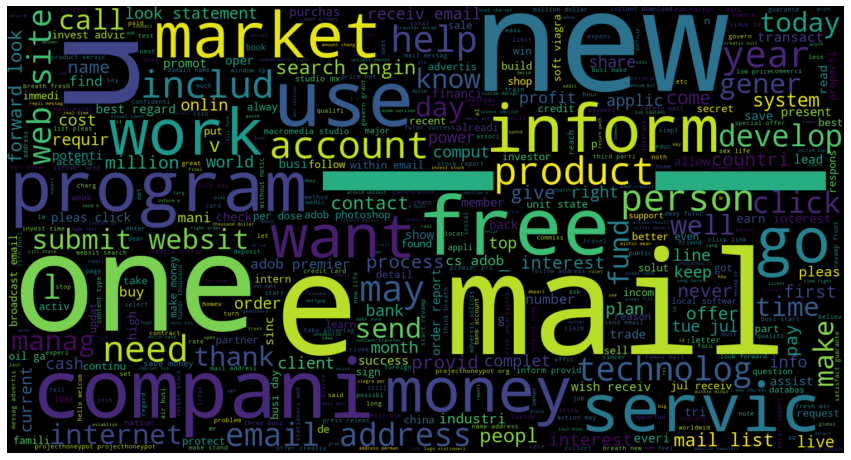

In [26]:
#6  Build a document term matrix from the dataset, called dtm.
from wordcloud import WordCloud
text = " ".join(data[data['spam'] == 1]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Problem 3.1 – Building machine learning models

In [27]:
import pandas as pd # for data manipulation
import numpy as np # for data manipulation

from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn import tree # for decision tree models

import plotly.express as px  # for data visualization
import plotly.graph_objects as go # for data visualization
import graphviz # for plotting decision tree graphs

In [28]:
# Set Pandas options to display more columns
pd.options.display.max_columns=50

In [29]:
def fitting(X, y, criterion, splitter, mdepth, clweight, minleaf):

    # Create training and testing samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Fit the model
    model = tree.DecisionTreeClassifier(criterion=criterion, 
                                        splitter=splitter, 
                                        max_depth=mdepth,
                                        class_weight=clweight,
                                        min_samples_leaf=minleaf, 
                                        random_state=0, 
                                  )
    clf = model.fit(X_train, y_train)

    # Predict class labels on training data
    pred_labels_tr = model.predict(X_train)
    # Predict class labels on a test data
    pred_labels_te = model.predict(X_test)

    # Tree summary and model evaluation metrics
    print('*************** Tree Summary ***************')
    print('Classes: ', clf.classes_)
    print('Tree Depth: ', clf.tree_.max_depth)
    print('No. of leaves: ', clf.tree_.n_leaves)
    print('No. of features: ', clf.n_features_in_)
    print('--------------------------------------------------------')
    print("")
    
    print('*************** Evaluation on Test Data ***************')
    score_te = model.score(X_test, y_test)
    print('Accuracy Score: ', score_te)
    # Look at classification report to evaluate the model
    print(classification_report(y_test, pred_labels_te))
    print('--------------------------------------------------------')
    print("")
    
    print('*************** Evaluation on Training Data ***************')
    score_tr = model.score(X_train, y_train)
    print('Accuracy Score: ', score_tr)
    # Look at classification report to evaluate the model
    print(classification_report(y_train, pred_labels_tr))
    print('--------------------------------------------------------')
    
    # Use graphviz to plot the tree
    dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X.columns, 
                                class_names=[str(list(clf.classes_)[0]), str(list(clf.classes_)[1])],
                                filled=True, 
                                rounded=True, 
                                #rotate=True,
                               ) 
    graph = graphviz.Source(dot_data)
    
    # Return relevant data for chart plotting
    return X_train, X_test, y_train, y_test, clf, graph

In [30]:
def Plot_3D(X, X_test, y_test, clf, x1, x2, mesh_size, margin):
            
    # Specify a size of the mesh to be used
    mesh_size=mesh_size
    margin=margin

    # Create a mesh grid on which we will run our model
    x_min, x_max = X.iloc[:, 0].fillna(X.mean()).min() - margin, X.iloc[:, 0].fillna(X.mean()).max() + margin
    y_min, y_max = X.iloc[:, 1].fillna(X.mean()).min() - margin, X.iloc[:, 1].fillna(X.mean()).max() + margin
    xrange = np.arange(x_min, x_max, mesh_size)
    yrange = np.arange(y_min, y_max, mesh_size)
    xx, yy = np.meshgrid(xrange, yrange)
            
    # Calculate predictions on grid
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)

    # Create a 3D scatter plot with predictions
    fig = px.scatter_3d(x=X_test[x1], y=X_test[x2], z=y_test,
                     opacity=0.8, color_discrete_sequence=['black'])

    # Set figure title and colors
    fig.update_layout(#title_text="Scatter 3D Plot with CART Prediction Surface",
                      paper_bgcolor = 'white',
                      scene = dict(xaxis=dict(title=x1,
                                              backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0'),
                                   yaxis=dict(title=x2,
                                              backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0'
                                              ),
                                   zaxis=dict(title='Probability of Rain Tomorrow',
                                              backgroundcolor='lightgrey',
                                              color='black', 
                                              gridcolor='#f0f0f0', 
                                              )))
    
    # Update marker size
    fig.update_traces(marker=dict(size=1))

    # Add prediction plane
    fig.add_traces(go.Surface(x=xrange, y=yrange, z=Z, name='CART Prediction',
                              colorscale='Jet',
                              reversescale=True,
                              showscale=False, 
                              contours = {"z": {"show": True, "start": 0.5, "end": 0.9, "size": 0.5}}))
    fig.show()
    return fig

In [31]:
data.columns

Index(['text', 'spam'], dtype='object')

In [32]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(data[["text"]])
data[["text"]] = enc.transform(data[["text"]])

In [33]:
Selected_features = ['text']

X = data[Selected_features]
y = data['spam']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#testing the correlation
#X_train.shape
#data.spam.describe()
#(data.spam == 0).sum()
#sns.pairplot(data[Selected_features].corr())
#plt.show()

In [34]:
data.head()

,text,spam
0,3275.0,1
1,4623.0,1
2,5012.0,1
3,72.0,1
4,3212.0,1


In [35]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf = clf.fit(X_train, y_train)
moonsY_pred = clf.predict(X_test)
rand_frst_score1 = clf.score(X_test, y_test)
print('random_forest_score: ',rand_frst_score1)
confusion_matrix(y_test, moonsY_pred)

random_forest_score:  0.7486033519553073


array([[1061,    2],
       [ 358,   11]])

*************** Tree Summary ***************
Classes:  [0 1]
Tree Depth:  2
No. of leaves:  3
No. of features:  1
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.7722513089005235
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       885
           1       0.00      0.00      0.00       261

    accuracy                           0.77      1146
   macro avg       0.39      0.50      0.44      1146
weighted avg       0.60      0.77      0.67      1146

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.7584024443474465
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      3475
           1       0.00      0.00      0.00      1107

    accuracy                           0.76      4582
   macro avg       0.38      0.50    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

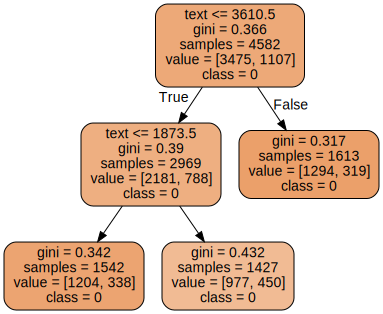

In [36]:
# Fit the model and display results
X_train, X_test, y_train, y_test, clf, graph = fitting(X, y, 'gini', 'best', 
                                                       mdepth=3, 
                                                       clweight=None,
                                                       minleaf=1000)

# Plot the tree graph
graph

# Save tree graph to a PDF
#graph.render('Decision_Tree_all_vars_gini')

# Performance obtained

**CART Decision Tree**

Training accuracy: 76%

Test accuracy:  77%


**Random Forest**

Test accuracy:  74%

Therefore the CART decision tree had the best accuracy and performance